In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib #pip install pathlib
import pyarrow as pa # conda install -c conda-forge pyarrow
import statsmodels.formula.api as smf #pip install statsmodels
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
# load in
DATA_PATH =  pathlib.Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")
F_NAME = "readmissions.csv"
hrrp_df = pd.read_csv(DATA_PATH / F_NAME, dtype_backend="pyarrow")

## Explore df

Lets check out our data types and null counts

In [3]:
hrrp_df.head()

,facility_name,facility_id,state,measure_name,number_of_discharges,footnote,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HIP-KNEE-HRRP,<NA>,<NA>,1.0301,4.5819,4.4481,Too Few to Report,7/1/18,6/30/21
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-COPD-HRRP,202,<NA>,0.9903,19.1885,19.3765,38,7/1/18,6/30/21
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,319,<NA>,0.9958,14.4888,14.5498,46,7/1/18,6/30/21
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,437,<NA>,0.9568,17.0029,17.7701,71,7/1/18,6/30/21
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,757,<NA>,1.0551,23.0374,21.8333,178,7/1/18,6/30/21


In [4]:
hrrp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18990 entries, 0 to 18989
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   facility_name               18990 non-null  string[pyarrow]
 1   facility_id                 18990 non-null  int64[pyarrow] 
 2   state                       18990 non-null  string[pyarrow]
 3   measure_name                18990 non-null  string[pyarrow]
 4   number_of_discharges        9339 non-null   int64[pyarrow] 
 5   footnote                    6071 non-null   int64[pyarrow] 
 6   excess_readmission_ratio    12919 non-null  double[pyarrow]
 7   predicted_readmission_rate  12919 non-null  double[pyarrow]
 8   expected_readmission_rate   12919 non-null  double[pyarrow]
 9   number_of_readmissions      12919 non-null  string[pyarrow]
 10  start_date                  18990 non-null  string[pyarrow]
 11  end_date                    18990 non-nul

In [5]:
# see why number of readmissions is listed as a string type
hrrp_df.value_counts("number_of_readmissions")

number_of_readmissions
Too Few to Report    3777
11                    358
12                    330
13                    297
15                    277
                     ... 
294                     1
296                     1
298                     1
417                     1
157                     1
Name: count, Length: 283, dtype: int64

I noticed that `number_of_readmissions` has entries "Too Few to Report" which makes pandas thing the column is a string, but we need to just switch that to an `Nan` for now.

In [6]:
# Replace with nans
hrrp_df['number_of_readmissions'] = hrrp_df['number_of_readmissions'].replace('Too Few to Report', np.nan)

# Convert from string -> numeric
hrrp_df['number_of_readmissions'] = pd.to_numeric(hrrp_df['number_of_readmissions'], errors='coerce')

# Print 
hrrp_df.value_counts("number_of_readmissions")

number_of_readmissions
11     358
12     330
13     297
15     277
14     272
      ... 
221      1
290      1
294      1
180      1
704      1
Name: count, Length: 282, dtype: int64

In [7]:
hrrp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18990 entries, 0 to 18989
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   facility_name               18990 non-null  string[pyarrow]
 1   facility_id                 18990 non-null  int64[pyarrow] 
 2   state                       18990 non-null  string[pyarrow]
 3   measure_name                18990 non-null  string[pyarrow]
 4   number_of_discharges        9339 non-null   int64[pyarrow] 
 5   footnote                    6071 non-null   int64[pyarrow] 
 6   excess_readmission_ratio    12919 non-null  double[pyarrow]
 7   predicted_readmission_rate  12919 non-null  double[pyarrow]
 8   expected_readmission_rate   12919 non-null  double[pyarrow]
 9   number_of_readmissions      9142 non-null   int64[pyarrow] 
 10  start_date                  18990 non-null  string[pyarrow]
 11  end_date                    18990 non-nul

### Measure Names

The names are quite long e.g. "READM-30-HIP-KNEE-HRRP". This would be a lot nicer as just "hip-knee" so I I'm going to remove the prefix, suffix & put into lowercase.

In [8]:
# Display the unique values in the 'measure_name' column
hrrp_df.measure_name.value_counts()

measure_name
READM-30-HIP-KNEE-HRRP    3165
READM-30-COPD-HRRP        3165
READM-30-AMI-HRRP         3165
READM-30-PN-HRRP          3165
READM-30-HF-HRRP          3165
READM-30-CABG-HRRP        3165
Name: count, dtype: int64[pyarrow]

In [9]:
# Remove READM-30 and -HRRP from the 'measure_name' column
hrrp_df['measure_name'] = hrrp_df['measure_name'].str.replace('READM-30-', '').str.replace('-HRRP', '')

# # Convert the values in the 'measure_name' column to lowercase
hrrp_df['measure_name'] = hrrp_df['measure_name'].str.lower()

# Display the unique values in the 'measure_name' column
hrrp_df.measure_name.value_counts()

measure_name
hip-knee    3165
copd        3165
ami         3165
pn          3165
hf          3165
cabg        3165
Name: count, dtype: int64[pyarrow]

### Raw readmissions rates (RRR)

Okay looks pretty good cleaning-wise. Lets use `number_of_discharges`, and `number_of_readmissions`, to calculate the `raw_readmission_rate`.

Then, I want to visualize the distribution of the RRR and then will assess the `predicted` and `expected` distributions. 

When creating the RR column, I'm going to convert this column from a pyarrow double to a simple float so it plays better with seaborn due to the Nan values.

In [10]:
# Generate rate
hrrp_df["raw_readmission_rate"] = hrrp_df.number_of_readmissions / hrrp_df.number_of_discharges * 100

# Convert to float
hrrp_df.raw_readmission_rate = hrrp_df.raw_readmission_rate.astype(float)

For about half of the data, we cannot calculate raw readmission rate because the number of readmissions was two few to report. This is determined by CMS to be < 11 readmissions (in FAQ).

In [11]:
hrrp_df.raw_readmission_rate.isnull().value_counts()

raw_readmission_rate
True     9848
False    9142
Name: count, dtype: int64

Based on the histogram below, raw readmission rate appears to be bimodal.

<Axes: xlabel='raw_readmission_rate', ylabel='Count'>

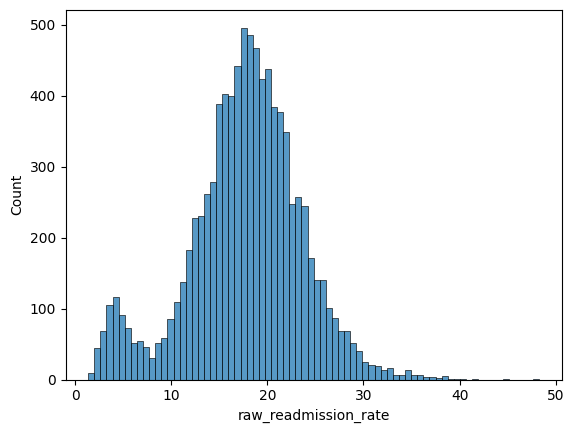

In [12]:
sns.histplot(data=hrrp_df, x="raw_readmission_rate")

Below, I am going to plot the relationship between all readmission variables we have access to- risk adjusted or raw. As a reminder these are defined as:

**predicted readmission rate**- the number of events (deaths, readmissions, or complications) within 30 days (or other timeframes for complications) that are predicted based on the hospital’s performance with its observed case mix

**expected readmission rate**- the number of outcomes expected based on the nation’s performance with that hospital’s case mix.

**excess ratio**- $\frac{\text{predicted}}{\text{expected}} * \text{national rate}$

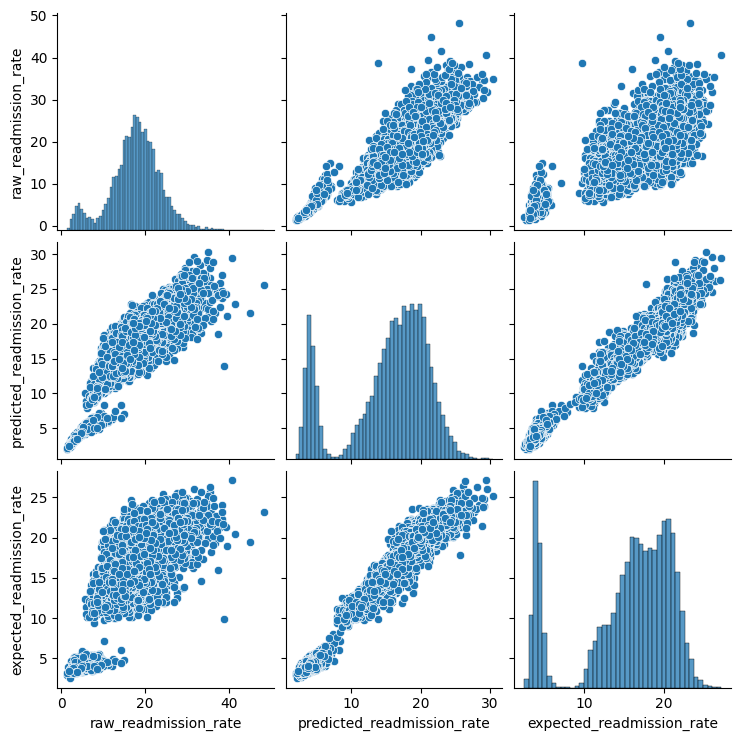

In [17]:
#TODO share x and y
plot_cols = [
    'raw_readmission_rate', 
    'predicted_readmission_rate', 
    'expected_readmission_rate', 
    # 'excess_readmission_ratio'
]

hrrp_df[plot_cols] = hrrp_df[plot_cols].astype(float)

sns.pairplot(hrrp_df[plot_cols])

Observations from the plot above:

Raw readmission rate is bimodal, but less so than predicted or expected.

There appears to be two clusters when plotting:
- raw vs predicted
- raw vs expected (more separable)

Predicted readmission rate is bimodal.

Expected & predicted appear to be mostly linear with a slight clustering for the smaller rates.

Expected is also bimodal, with lower peak appearing to have the largest mass.

***
The plot below incorporates the excess readmission ratio (ERR). When ERR is plotting against any of the rates, it becomes two distinct clusters that appear more evenly split (right column).

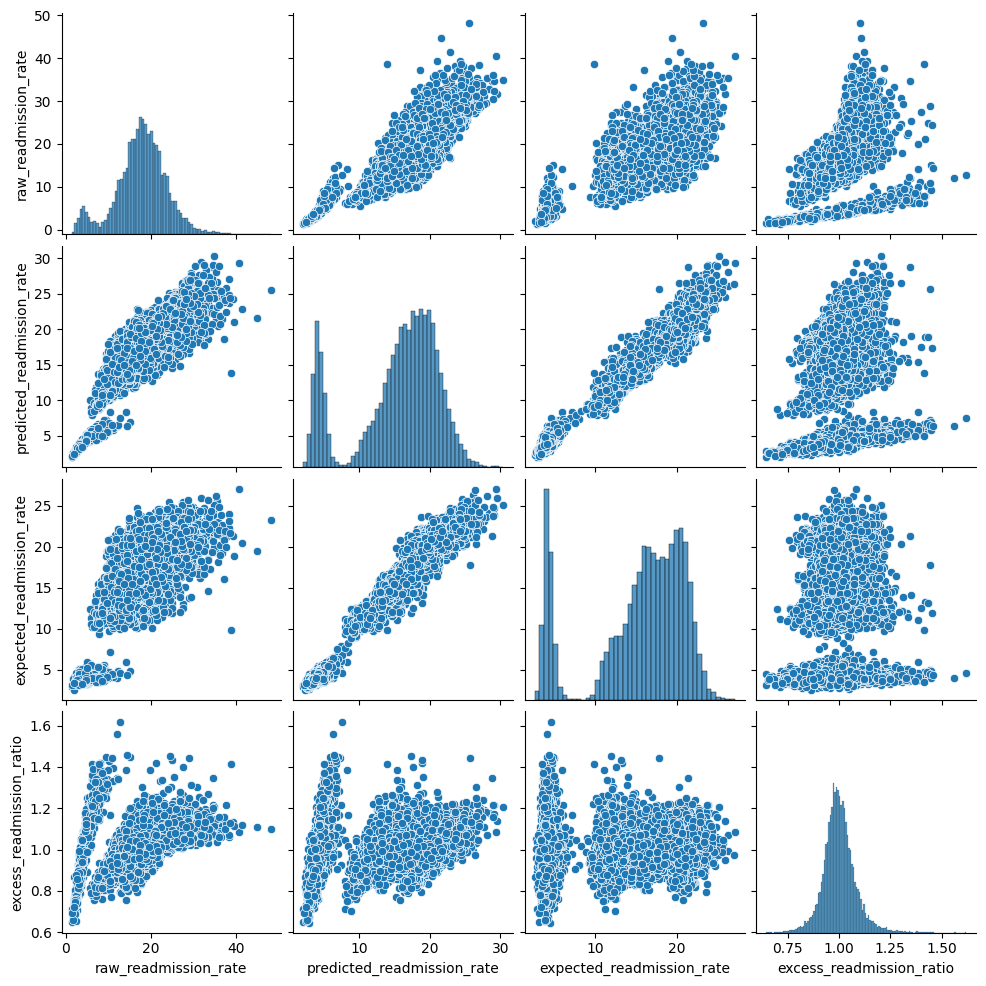

In [14]:
#TODO share x and y
plot_cols = [
    'raw_readmission_rate', 
    'predicted_readmission_rate', 
    'expected_readmission_rate', 
    'excess_readmission_ratio'
]

hrrp_df[plot_cols] = hrrp_df[plot_cols].astype(float)

sns.pairplot(hrrp_df[plot_cols])

If you color by ERR (below), there appears to be some trends:

The higher raw readmissions ate, the higher the ratio. Same for predicted readmission rate. For Expected vs predicted, it appears that the higher the expected readmission rate is, the lower the ERR is.

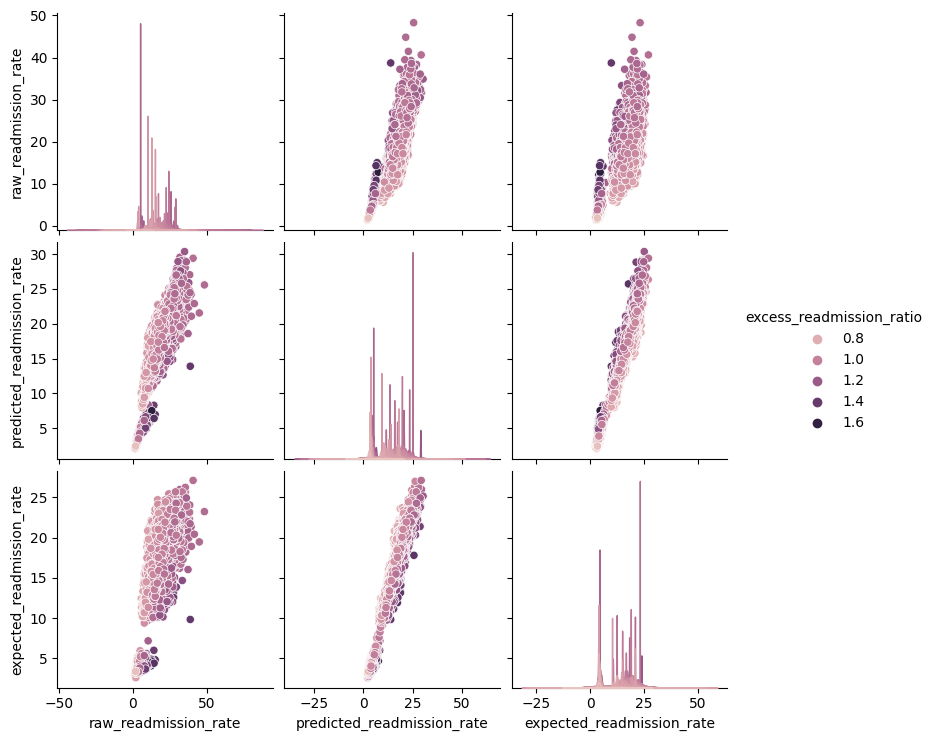

In [18]:
# TODO make histograms better here

plot_cols = [
    'raw_readmission_rate', 
    'predicted_readmission_rate', 
    'expected_readmission_rate', 
    'excess_readmission_ratio'
]

sns.pairplot(hrrp_df[plot_cols], hue="excess_readmission_ratio")

It would be nice to figure out why those clusters exist- maybe the type of procedure has something to do with it. I'm going to color by that.

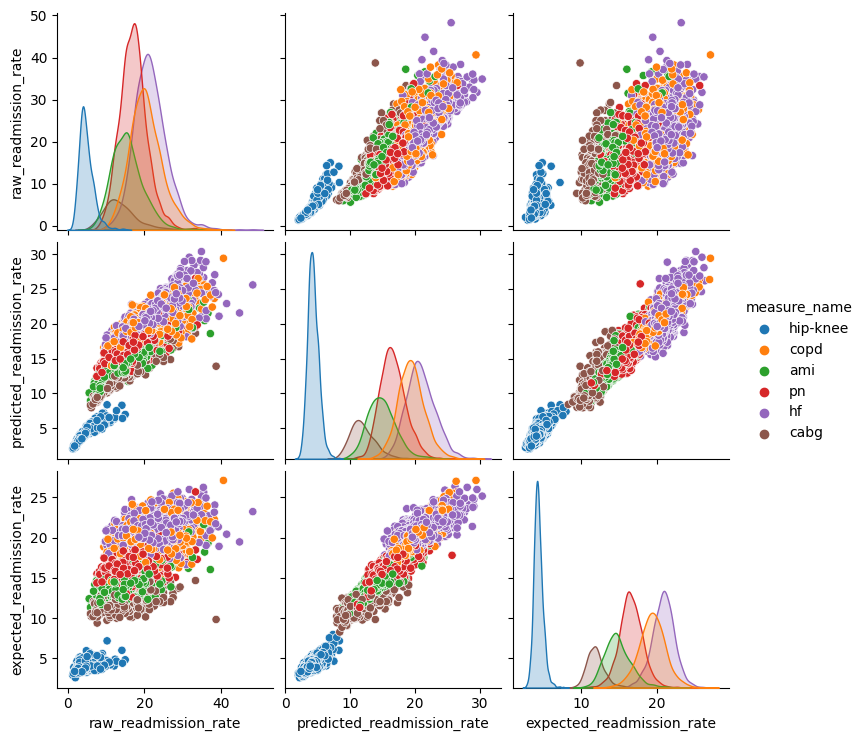

In [ ]:
plot_cols = [
    'raw_readmission_rate', 
    'predicted_readmission_rate', 
    'expected_readmission_rate', 
    'measure_name'
]

sns.pairplot(hrrp_df[plot_cols], hue="measure_name")

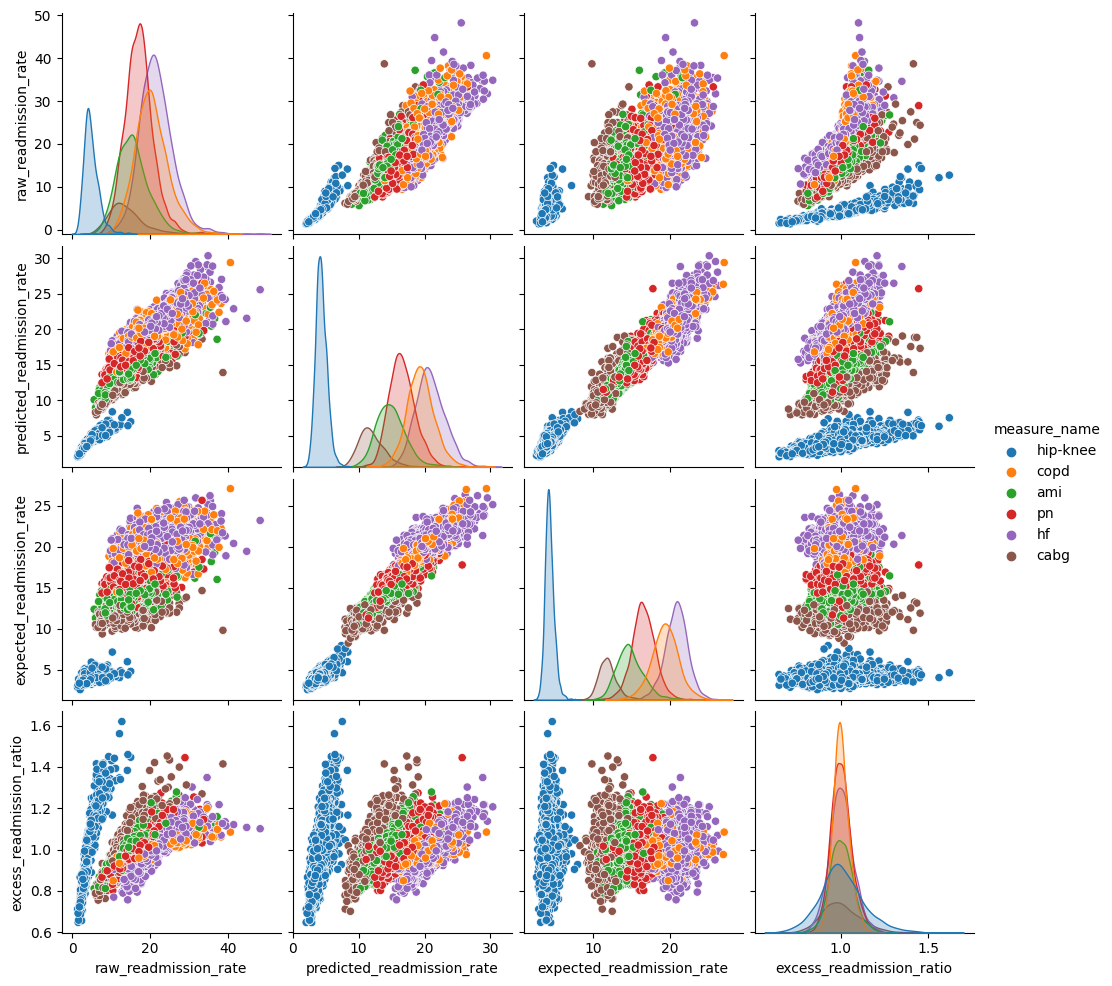

In [ ]:

plot_cols = [
    'raw_readmission_rate', 
    'predicted_readmission_rate', 
    'expected_readmission_rate', 
    'excess_readmission_ratio',
    'measure_name'
]

sns.pairplot(hrrp_df[plot_cols], hue="measure_name")

Okay- that is quite informative! The lower cluster we were seeing was definitely the hip-knee group (blue). Additionally, you can see clusters forming in the other plots. For example, heart failure (hf, purple) is generally higher than all the other measures.

The top left plot (kde of raw readmission rate) appears to have more overlap across all the groups. Moreover the hip-knee sample appears to be smaller. This is likely due to more nans in this measure group with respect to the raw numbers.


When comparing the distributions of the readmission rates via box plots, you can see that the raw readmission rate has a higher median and larger spread when compared to the risk adjusted metrics.

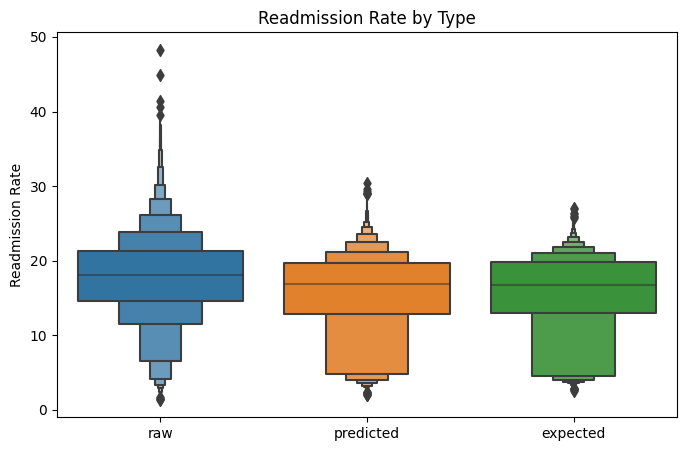

In [ ]:
# Make a long form dataframe to get all the rates into one column
rr_df = hrrp_df.melt(
    id_vars='facility_id',
    value_vars=[
        'raw_readmission_rate', 
        'predicted_readmission_rate', 
        'expected_readmission_rate',
        ],
    var_name="readmission_type",
    value_name="rate",
)

fig,ax = plt.subplots(figsize=(8,5))
sns.boxenplot(data=rr_df, x="readmission_type", y="rate")
_ = ax.set_xticklabels(['raw', 'predicted', 'expected'])
_ = ax.set(ylabel="Readmission Rate", xlabel="", title="Readmission Rate by Type")


I want to investigate the tri-variate relationship between these variables by plotting two of them against each other on x & y and coloring by a third.

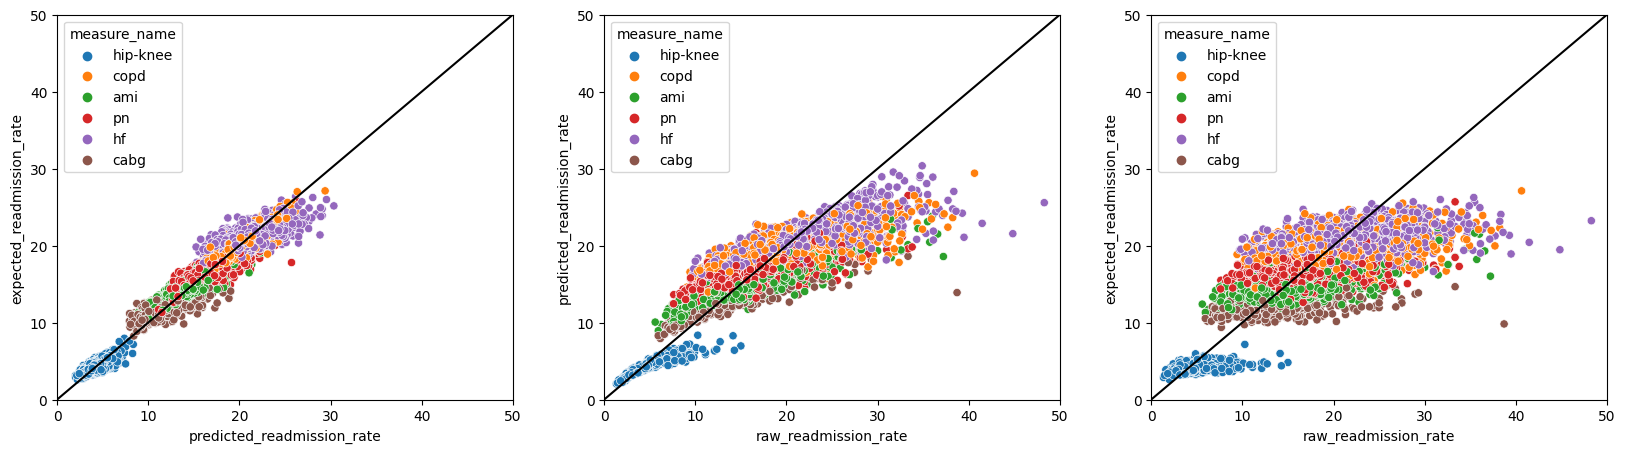

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(20,5))

sns.scatterplot(
    data=hrrp_df,
    x="predicted_readmission_rate", 
    y="expected_readmission_rate",
    hue="measure_name",
    ax=ax[0]
)
sns.scatterplot(
    data=hrrp_df,
    x="raw_readmission_rate", 
    y="predicted_readmission_rate",
    hue="measure_name",
    ax=ax[1]
)
sns.scatterplot(
    data=hrrp_df,
    x="raw_readmission_rate", 
    y="expected_readmission_rate",
    hue="measure_name",
    ax=ax[2]
)


# add in unity line & make axes match
for i in range(len(ax)):
    ax[i].axline([0,0], [1,1], color="k")
    ax[i].set(ylim=(0,50), xlim=(0,50))

Similar to the pair plots above, but easier to see now, the expected vs predicted plot appears to be close to the unity line. When colored by measure type, there seems to be some distinct clusters going from hip -> hf.

When looking at raw readmission rate versus predicted colored by measure name. the relationship appears sub-linear and again has two clusters (hip-knee versus others). The segregation between clusters is less prevalent here. 

When looking at raw readmission rate versus expected colored by measure name, the hip-knee versus other cluster is more separated. Moreover, the linear relationship between the variables is the weakest, but clustering is a bit cleaner than the raw vs predicted. 

### Difference between raw & risk adjusted

To assess the differences in the raw versus risk adjusted score, I will calculate the difference between raw & predicted, raw & expected and plot the resulting distribution


In [ ]:

# Generate rate
hrrp_df["raw-predicted"] = hrrp_df.raw_readmission_rate - hrrp_df.predicted_readmission_rate
hrrp_df["raw-expected"] = hrrp_df.raw_readmission_rate - hrrp_df.expected_readmission_rate


<Axes: xlabel='variable', ylabel='difference'>

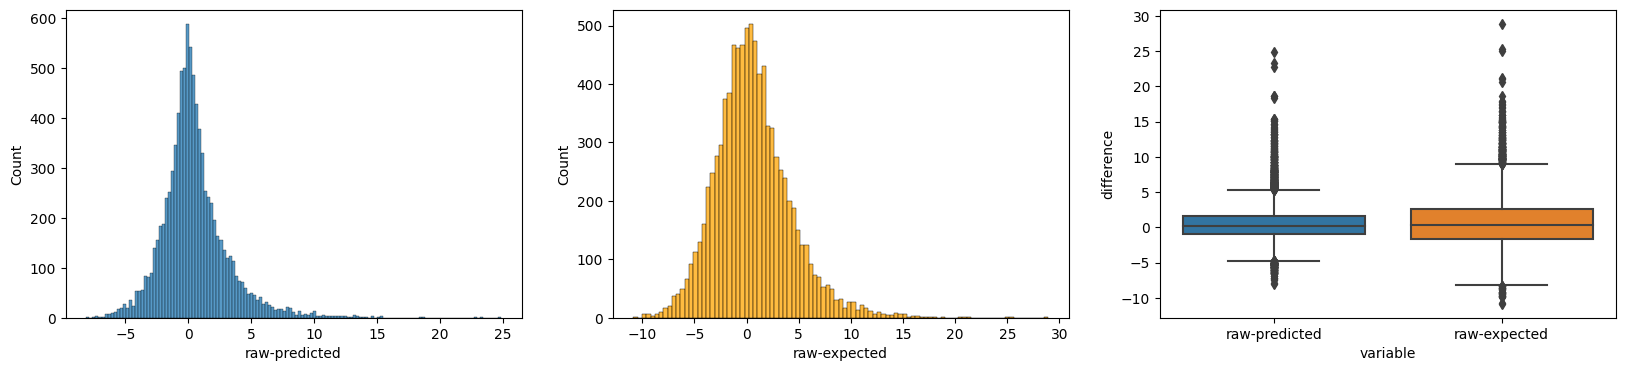

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(20,4))

sns.histplot(hrrp_df, x="raw-predicted", ax=ax[0])
sns.histplot(hrrp_df, x="raw-expected", ax=ax[1], color="orange")

diff_df = hrrp_df.melt(
    id_vars="facility_id"
    value_vars=["raw-predicted", "raw-expected"],
    value_name="difference"
)

sns.boxplot(
    data=diff_df, 
    y="difference",
    x="variable",
    ax=ax[2]
)


The plots above sow that the difference data is distributed around 0 for both risk adjusted variables with a slight right skew. The boxplots show that the raw-expected difference has a larger spread than the raw-predicted and both variables have a similar median.

When looking at the statistics of the distribution (below), we see that that on average, the difference is 0.48% and 0.62% for the predicted and expected rates, respectively. The minimum adjustment (~8, -10%) is smaller in magnitude than the maximum adjustment (24%, 28%). This suggests the risk adjusted rates generally **decreases** a hosptial's readmission score

In [ ]:
diff_cols = ["raw-predicted", "raw-expected"]

hrrp_df[diff_cols].describe()

,raw-predicted,raw-expected
count,9142.000000,9142.000000
mean,0.481164,0.622359
std,2.649978,3.650471
min,-8.086726,-10.837800
25%,-0.962564,-1.722486
50%,0.153253,0.304565
75%,1.561750,2.562445
max,24.813977,28.886477


#### By condition

When breaking apart the difference by condition- each condition seems to have a similar amount of risk adjustment (medians all near 0). Again, the expected has a larger range of differences than the predicted risk adjusted value when compared to the raw, non-adjusted readmission value.

<Axes: xlabel='measure_name', ylabel='difference'>

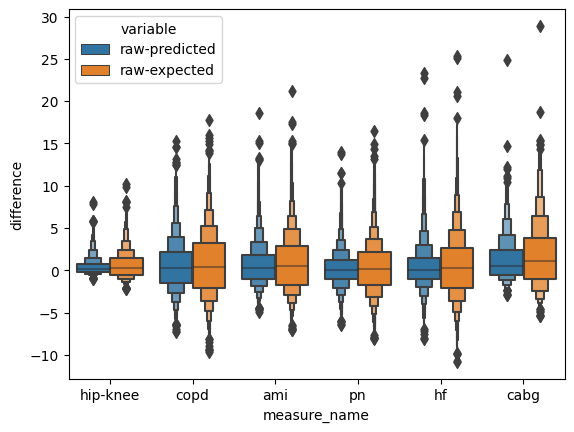

In [ ]:
diff_measure_df = hrrp_df.melt(
    id_vars="measure_name",
    value_vars=["raw-predicted", "raw-expected"],
    value_name="difference"
)

sns.boxenplot(
    data=diff_measure_df,
    x="measure_name",
    y="difference",
    hue="variable",
)

#### By State

Conditioned on state, there doesn't appear to be any obvious outlier states with respect to adjustment or the raw rate. To improve this, I would make this a geo plot and/or incorporate other state features (e.g. population, avg hospital score, avg income, etc.) like we plan to do with SDOH.

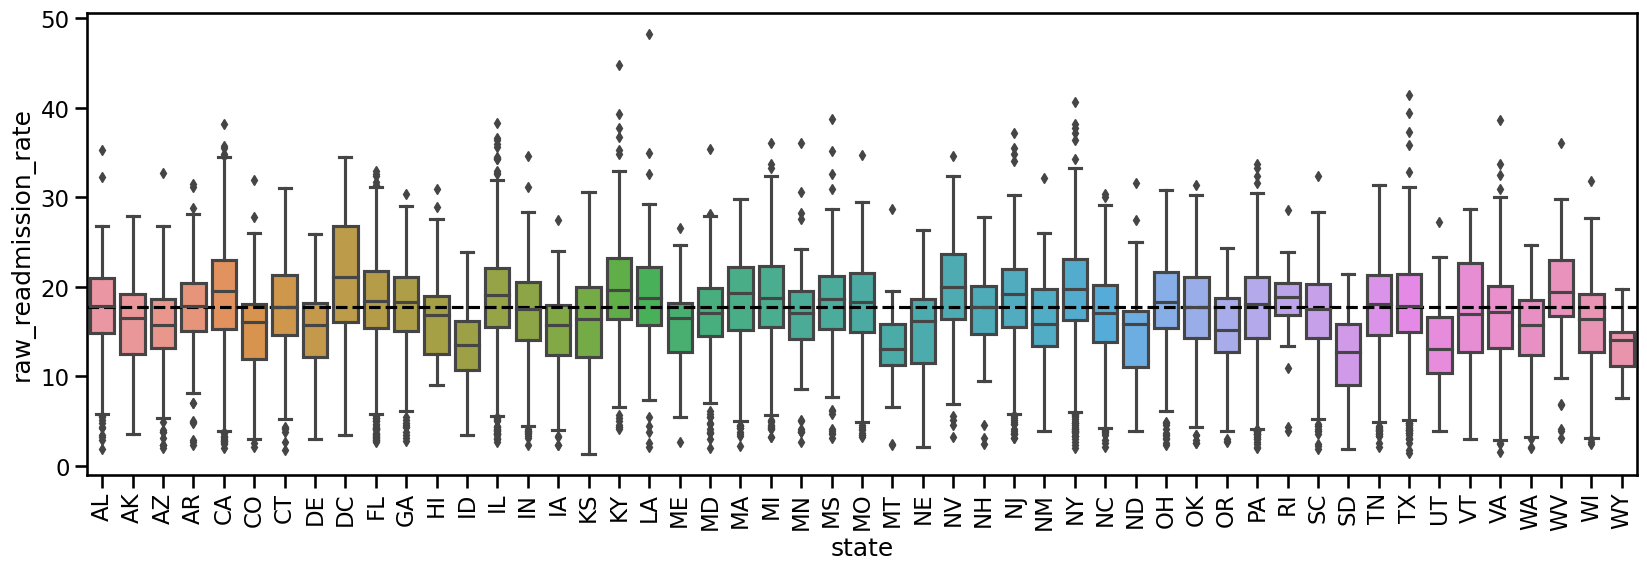

In [ ]:
fig,ax=plt.subplots(figsize=(20,6))


sns.boxplot(
    data=hrrp_df,
    x="state",
    y="raw_readmission_rate",
)

ax.axhline(y=hrrp_df["raw_readmission_rate"].mean(), color="k", linestyle="--")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)



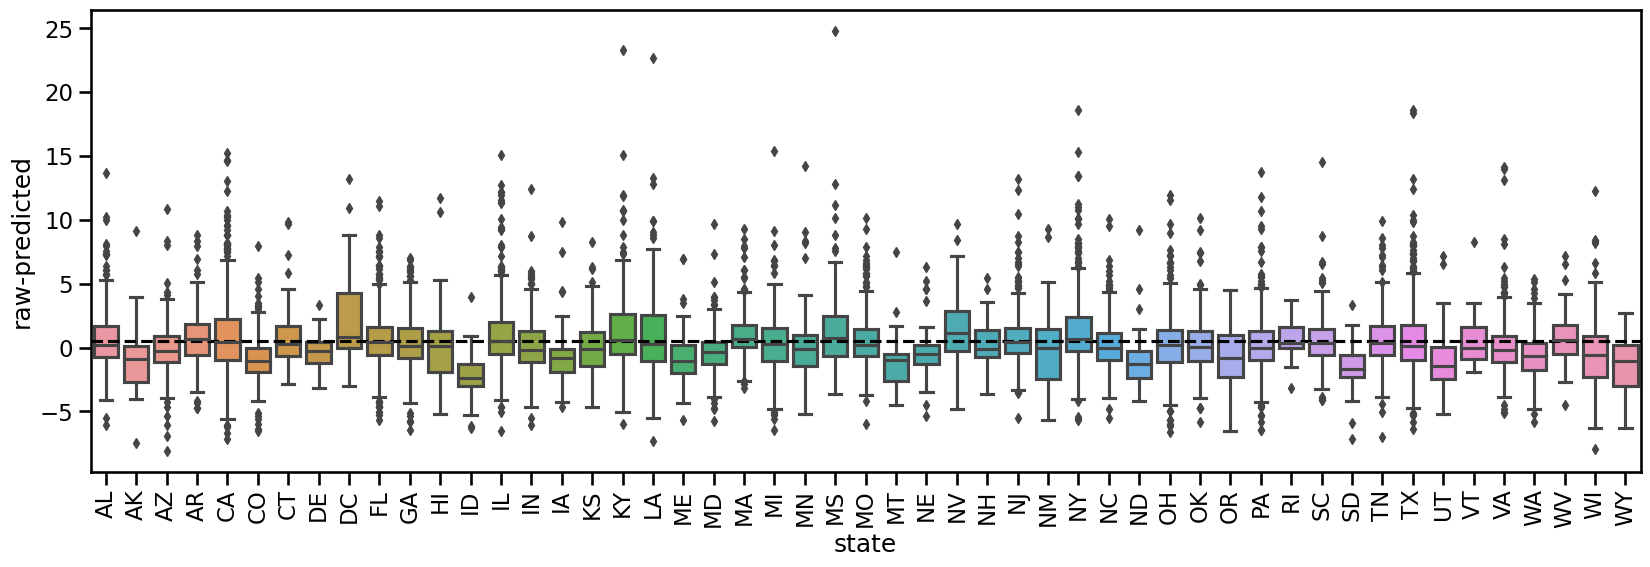

In [ ]:
fig,ax=plt.subplots(figsize=(20,6))

sns.boxplot(
    data=hrrp_df,
    x="state",
    y="raw-predicted",
)

ax.axhline(y=hrrp_df["raw-predicted"].mean(), color="k", linestyle="--")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


### Conditions

We don't have access to hospital wide data, so we will likely need to focus on a condition. Lets see how the **raw readmission** rate varies by measure type (note, this is only for non-null values)

In [ ]:
hrrp_df.groupby('measure_name').raw_readmission_rate.describe()

,count,mean,std,min,25%,50%,75%,max
measure_name,,,,,,,,
ami,1314.0,15.609180,4.288505,5.603448,12.610927,15.227834,17.874882,37.209302
cabg,411.0,13.813731,4.522334,5.936073,10.781378,12.931034,15.909091,38.709677
copd,1945.0,20.400759,4.288707,9.090909,17.514124,20.000000,22.950820,40.625000
hf,2419.0,21.519234,4.325185,9.714286,18.604651,21.172638,24.000000,48.275862
hip-knee,670.0,4.821558,1.917899,1.351351,3.569273,4.430380,5.762541,15.000000
pn,2383.0,17.086459,3.569470,7.619048,14.754098,16.974170,19.127517,33.783784


Copd, Heart Failure (hf) and Pneumonia (pn) have the most number of cases. And hf has the highest readmission rate. Lets see what the distributions look like. 

<Axes: xlabel='raw_readmission_rate', ylabel='Count'>

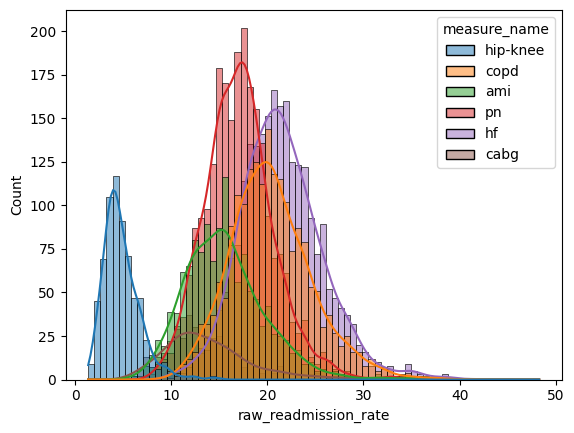

In [ ]:
sns.histplot(data=hrrp_df, x="raw_readmission_rate", hue="measure_name", kde=True)

Below is a visualization of the table mentioned above showing distribution of readmission rates by measure id. This boxenplot shows IQR ranges with the height of the box proportional to the number of datapoints in the quartile. The median is indicated by the middle line. Hf has the highest readmission rate, followed by copd, pn, ami, cabg and then hip and knee. The hip-knee group rr appears much lower than others (and has the most number of missing values due to "too few to report"). 

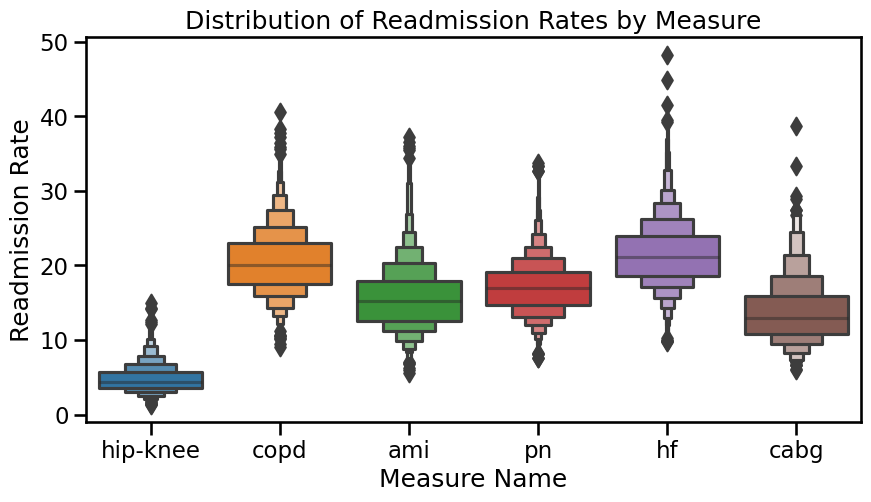

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
sns.set_context("talk")
sns.boxenplot(
    data=hrrp_df,
    x="measure_name",
    y="raw_readmission_rate", 
    ax=ax)
_ = ax.set(title="Distribution of Readmission Rates by Measure", xlabel="Measure Name", ylabel="Readmission Rate")

A one-way ANOVA below shows there is a significant difference in means between the groups. But a post-hoc Tukey test fails to reject the null hypothesis of any significant difference in means between groups pairs. This may be due to variations in sample size that we saw above (e.g hip-knee has far fewer cases than pn).

In [ ]:
# Switch to catgory type since statmodels doesn't like pyarrow
hrrp_df['measure_name_cat'] = hrrp_df.measure_name.astype('category')

# Fit a linear regression model of readmission ~ measure
model = smf.ols('raw_readmission_rate ~ C(measure_name_cat)', data=hrrp_df).fit()

# Perform an ANOVA test on the fitted model 
anova_results = anova_lm(model)

# Display results
anova_results

,df,sum_sq,mean_sq,F,PR(>F)
C(measure_name_cat),5.0,173442.496471,34688.499294,2165.703886,0.0
Residual,9136.0,146333.084415,16.017194,NaN,NaN


In [ ]:
tukey_results = pairwise_tukeyhsd(
    hrrp_df['raw_readmission_rate'],
    hrrp_df['measure_name_cat']
)

tukey_results.reject

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

### Assessing Null Values of RRRs

In [ ]:
# Group the DataFrame by the 'measure_name' column
measure_group = hrrp_df.groupby('measure_name')

# Find the number of NaN values in the 'raw_readmission_rate' column for each category
measure_group.agg({'raw_readmission_rate': lambda x: x.isnull().sum()})

result = measure_group.agg(
    num_nulls=pd.NamedAgg(column='raw_readmission_rate', aggfunc=lambda x: x.isnull().sum()),
    num_non_nulls=pd.NamedAgg(column='raw_readmission_rate', aggfunc=lambda x: x.notnull().sum()),
    null_rate=pd.NamedAgg(column='raw_readmission_rate', aggfunc=lambda x: x.isnull().mean() * 100)
)

result['readmission_rate'] = measure_group['raw_readmission_rate'].mean()

result = result.reset_index()
result.sort_values('num_non_nulls', ascending=False)

,measure_name,num_nulls,num_non_nulls,null_rate,readmission_rate
3,hf,746,2419,23.570300,21.519234
5,pn,782,2383,24.707741,17.086459
2,copd,1220,1945,38.546603,20.400759
0,ami,1851,1314,58.483412,15.609180
4,hip-knee,2495,670,78.830964,4.821558
1,cabg,2754,411,87.014218,13.813731


The highest null rates are for CABG, HIP-KNEE and AMI. This supports the finding from the .describe() above that COPD, HF or PN might be best to focus on with ordering HF > PN > COPD. This is taking into account the count of non nulls and the frequency of readmissions. 

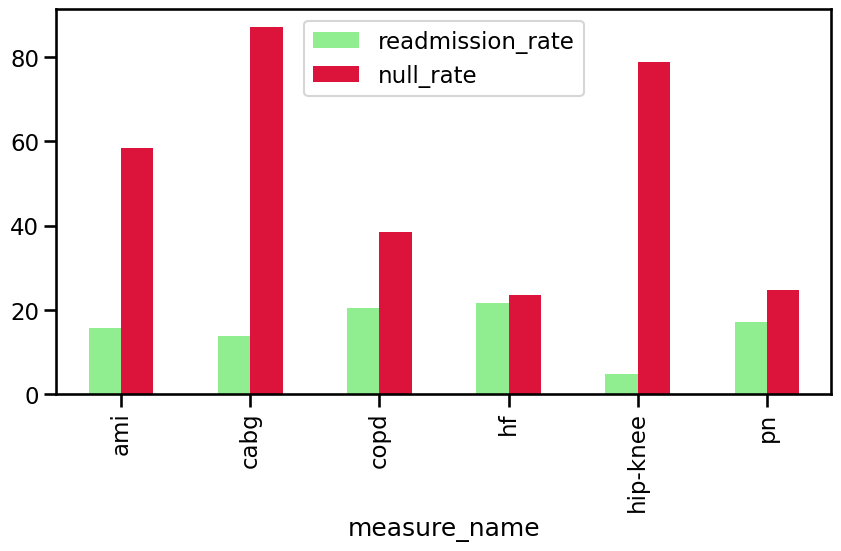

In [ ]:
result.plot(kind="bar", x="measure_name", y=["readmission_rate", "null_rate"], color=["lightgreen", "crimson"], figsize=(10,5))
plt.ylabel="Rate"